# Generating Mock LCs and Downsampling

This notebook will focus on showing how to generate mock LCs using Kali and downsample mock LCs at LSST cadence.  

The AGN variablity can be well described by the continuous-time autoregressive moving average (CARMA) process. CARMA processes are defined as solutions to the differential equation
 
$$\mathrm{d}^{p}x + \alpha_{1} \mathrm{d}^{p-1}x + \ldots + \alpha_{p-1} \mathrm{d}x + \alpha_{p}x = \beta_{0} (\mathrm{d}W) + \ldots + \beta_{q} \mathrm{d}^{q}(\mathrm{d}W).$$

$W$ on the RHS is a *Wiener Process* which introduces stochasticity into the behavior of $x$. $\alpha$ and $\beta$ are coefficients for the process. The order of a CARMA(p,q) process is configured by $p$ and $q$, which are introduced in the differential equation above. For stationality, we must requre $p>q$. The total number $\alpha$ on the LHS equals $p$, and the total number of $\beta$ equals $q+1$.

For modeling AGN variablity, we are interested in two CARMA process, CARMA(1,0)/DRW and CARMA(2,1)/DHO. The corresponding differential equations are shown below: 

**CARMA(1,0)**  
$$\mathrm{d}x + \alpha_{1}x = \beta_{0} (\mathrm{d}W)$$  

**CARMA(2,1)**
$$\mathrm{d}^{2}x + \alpha_{1} \mathrm{d}x + \alpha_{2}x = \beta_{0} (\mathrm{d}W) + \beta_{1} \mathrm{d}^{1}(\mathrm{d}W)$$   

Detailed description on the statistical modeling of AGN vairability using CARMA(2,1) process is available in [Kasliwal et al. 2017](http://arxiv.org/abs/1607.04299%0Ahttp://dx.doi.org/10.1093/mnras/stx1420). For CARMA(1,0)/DRW modeling, please checkout the paper [Kelly et al. 2009](http://stacks.iop.org/0004-637X/698/i=1/a=895?key=crossref.5b2e0302150fe3a65396df42db247372). For CARMA modeling in general, please look at [Kelly et al. 2014](http://iopscience.iop.org/article/10.1088/0004-637X/788/1/33/meta). These three papers above might have used slightly different notaions and definitions of terms. Here, we are following the standard introduced in Kasliwa et al. 2017.

## 2. Generating Mock LC

In [1]:
%matplotlib inline

/home/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### 2.1 Load cadence from npz file 

In [5]:
# load MAF output from file, which was saved from the obs_hist notebook
maf = np.load('/home/mount/MAF output/58_-27_bl.npz') 

# get the result for minion_1016, baseline cadence
bl_meta = maf['meta'] # [ra, dec, min_sep, opsim_id], min_sep in hours
bl_cadence = maf['cadence'] # cadence in structured array
min_sep = float(bl_meta[2])

----

We use Kali, a software written by Vishal P. Kasliwal, to generate mock LCs and to estimate CARMA coefficients from downsampled LCs. A detailed walk through of Kali's functionality is avaiable [here](https://github.com/AstroVPK/kali/blob/master/guide/Introduction.ipynb).

### 2.2 CARMA(1,0)/DRW

First, we need to initiate a CARMA task. A CARMA task can be used for both simulating mock LCs and to estimation parameters.  

Available arguments for CARMATask:
1. **nthreads: **number of hardware threads(defaults to the number of threads supported by cpu)
2. **nburn: **Number of light curve steps to burn(defaults to 1,000,000)
3. **nwalker: **Number of MCMC walkers(defaults to 25\*nthreads)
4. **nsteps: **Number of MCMC steps(defaults to 250)
5. **maxEvals: **Maximum number of evaluations when attempting to find starting location for MCMC(defaults to 10,000)
6. **xTol: **Fractional tolerance in optimized parameter value(defaults to 0.001)

In [6]:
# Initiate carma task
drwTask = kali.carma.CARMATask(1,0,nsteps = 500)

Before simulating LCs, we need to specify the coefficients ($\alpha$ and $\beta$) for the paricular model and also how frequently do we want the mock LC to be sampled, namely dt. Mathematically, an individual C-ARMA model can be specified using either the coefficients representation or the roots representation. The roots representation is much more convenient to use, because for the DRW model, the real part of the root equals minus the inverse of $\tau$ (the relaxation timescale). However, Kālī requires that the C-ARMA model be specified purely in terms of the C-ARMA model coefficients and provides helper functions to convert the roots representation to the coeffiecients represenation. In the root representation, the number of autoregressive(AR) roots equals $p$, the number of moving average(MA) roots equals $q$. The last root coefficients is the variablity amplitude or the square root of the asymptotic autocorrelation function of the light curve (I assume it is the long-term standard devitation of the light curve or $\sigma$ as in [MacLeod et al. 2010](http://iopscience.iop.org/article/10.1088/0004-637X/721/2/1014), not 100% sure, might off by a factor)

In [7]:
# declare input roots and amplitude(amp), organize in an array
r_1 = (-1.0/150.0) + 0j 
amp = 1.0 
drwRho = np.array([r_1, amp])

# use helper function to convert input to coefficients, and check whether valid
drwTheta = kali.carma.coeffs(1, 0, drwRho) # use the array of roots above to solve for coefficients
print drwTheta # print out the calculated coefficients
print drwTask.check(drwTheta)

[ 0.00666667  0.11547005]
True


#### Simulate DRW LC

In [8]:
dt = np.floor(min_sep*3600-1)/86400 # convert min_sep from hours to days, Kali uses days (floor to avoid dim error)
drwTask.set(dt, drwTheta) # Will print 0 if parameters set successfuly

0

In [9]:
drw_lc = drwTask.simulate(duration=3650)

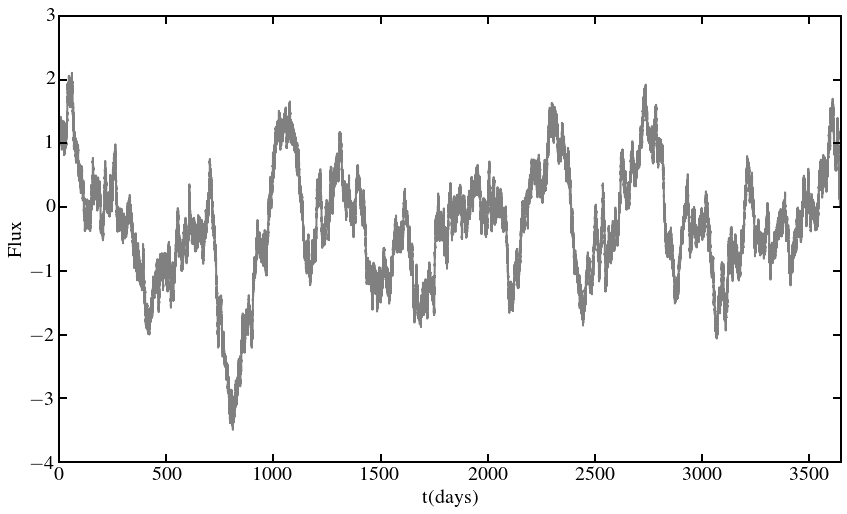

In [10]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.xlim(0,3650)
plt.plot(drw_lc.t, drw_lc.x, color='gray') # x is the variation about the mean flux

The LC plot above only shows the varing part of the flux. The absolute flux (absFlux) is determined by the attribute `fracIntrisicVar` of the corresponding LC object, namely  

> meanFlux = varFlux/fracIntrisicVar   
> absFlux = meanFlux + varFlux

The varFlux is the flux shown in the LC plot above or the $x$ values of the LC object.  

#### Add noise (SNR = 100)

In [11]:
drw_lc.fracNoiseToSignal = 0.01
drwTask.observe(drw_lc)

The noise is drawn from a zero-mean gaussian distributiuon where the standard deviation of the gaussian (noise_level) is determined as follow:

> noise_level = absFlux\*fracNoiseToSignal

Where `fracNoiseToSignal` is an attribute of the LC object, which can be set mannually before simulating noise. Finally:

> obsFlux = absFlux + noise

Noise is randomly drawn from the gaussian and `obsFlux` is stored as $y$ in the LC object. `noise_level` is stored as $yerr$.

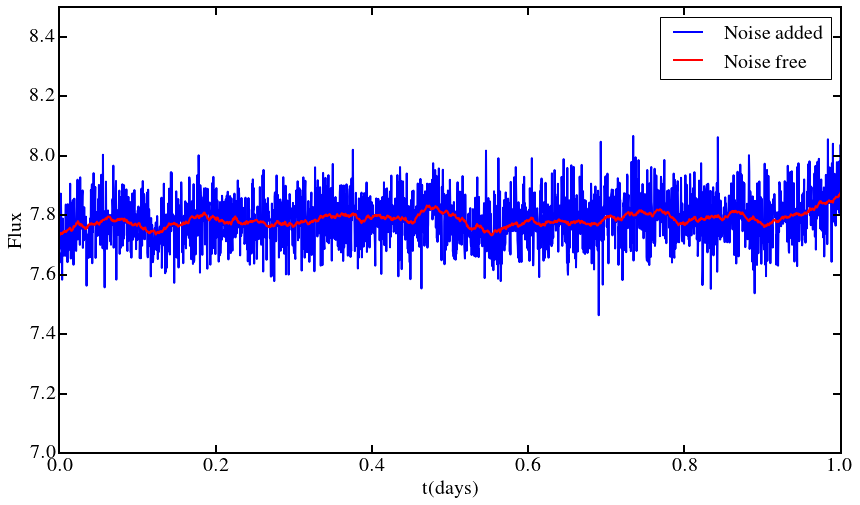

In [14]:
# compare LCs before and after adding noise
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.xlim(0,1)
plt.ylim(7,8.5)
plt.plot(drw_lc.t, drw_lc.y, label='Noise added')
plt.plot(drw_lc.t, drw_lc.x + np.mean(drw_lc.y) - np.mean(drw_lc.x), label='Noise free', color='r')
plt.legend()

#### Save LC to file

In [15]:
lc2file('/home/mount/LC/drw_full', drw_lc)

### 2.3 CARMA(2,1)/DHO

The DHO model has two more coefficents than the DRW model. In the root representation, DHO requires four parameter, two AR roots, one MA root and one light curve variability amplitude. Again the inverse of the real part of the AR root is the minus of the relaxation timescale. So, for DHO we will have two relaxation timescales. Bellow, we are simulation a DHO LC with $\tau_{1}$ = 107.8 days, $\tau_{2}$ = 33.2 days and MA timescale of 5.5 days. The variability amplitude is the same as in DRW LC. 

In [32]:
# Initiate carma task
dhoTask = kali.carma.CARMATask(2,1,nsteps = 1000)

In [33]:
# declare input timescales and amplitude, organize in an array
r_1 = (-1.0/107.8) + 0j
r_2 = (-1.0/33.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0

dhoRho = np.array([r_1, r_2, m_1, amp]) # put the selected paramenters into array format
dhoTheta = kali.carma.coeffs(2, 1, dhoRho) # use the array of roots above to solve for coefficients
print dhoTheta # print out the calculated coefficients
print dhoTask.check(dhoTheta) # check whether computed coefficients make sense, if True then OK

[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
True


In [34]:
# dt is same as for drw lc
dhoTask.set(dt, dhoTheta) # Will print 0 if parameters set successfuly

0

#### Simulate DHO LC

In [37]:
dho_lc = dhoTask.simulate(duration=3650)

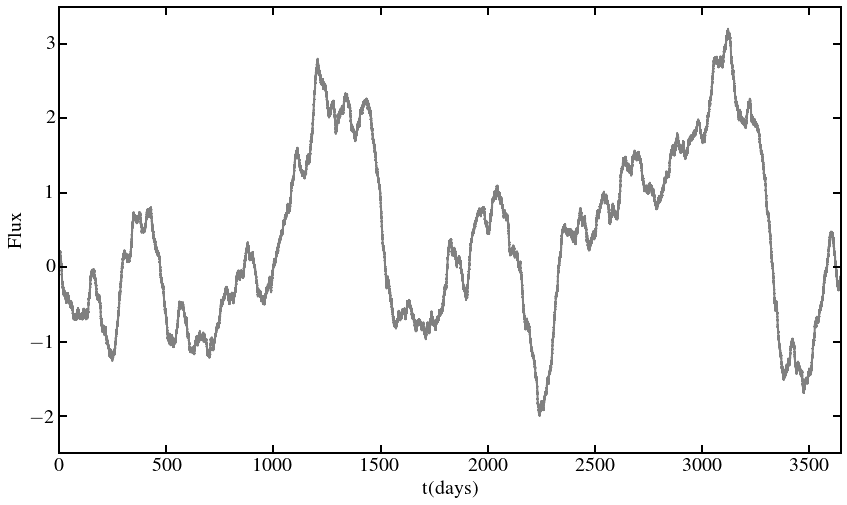

In [41]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.xlim(0,3650)
plt.ylim(-2.5, 3.5)
plt.plot(dho_lc.t, dho_lc.x, color='gray') # x is the variation about the mean flux

#### Add noise (SNR 100)

In [38]:
dho_lc.fracNoiseToSignal = 0.01
dhoTask.observe(dho_lc)

#### Save to file

In [42]:
lc2file('/home/mount/LC/dho_full', dho_lc)

## 3. DownSampling Mock LCs